In [117]:
%matplotlib inline

In [118]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import scipy as sp

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

In [119]:
##Steps to discretize events##

#generate parameters with uniform_param_generator
#generate simulated event (Python dictionary obect) (COULD ADD NOISE HERE?)  - seems to make more sense during generation
#convert simulated events to Event objects
#write this to our h5

#load h5 file and give it to discretizatio function
#loop through all events in h5 discretizing by taking evt.xyzs (COULD ADD NOISE HERE?)
#save discretized events to sparse csr_matrix

In [120]:
with open('/home/taylor/Documents/independent-research/req-files/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']

gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 20

In [153]:
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [154]:
p = next(pgen)

# p[0][0] = -0.00791423
# p[0][1] =  0.0030299
# p[0][2] = 0.56803276
# p[0][3] = 1.83097548
# p[0][4] =  0.11137931
# p[0][5] =  2.01473709

print(p)

(array([ 6.95859717e-04, -1.30127336e-02,  5.79420941e-01,  1.31514527e+00,
        3.28049991e+00,  1.92790986e+00]), array([ 0.00124099, -0.02320675, -0.99972992]))


In [155]:
sim = EventSimulator(config)

In [156]:
evt, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
print(len(evt))

360


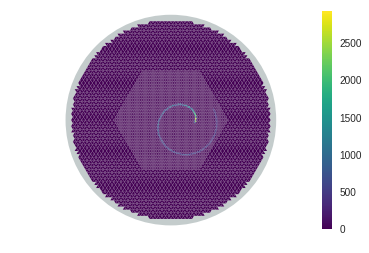

In [158]:
hits = np.zeros(10240)
for k, v in evt.items():
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

# Adding Random Noise

In [159]:
print(type(evt))

<class 'dict'>


In [160]:
print(evt.keys())

dict_keys([121, 122, 123, 124, 125, 126, 127, 203, 204, 205, 206, 207, 208, 249, 250, 251, 252, 253, 254, 256, 421, 422, 423, 424, 425, 426, 427, 428, 500, 501, 502, 503, 504, 545, 546, 547, 548, 549, 550, 551, 716, 717, 719, 720, 721, 722, 723, 726, 728, 787, 789, 790, 791, 792, 794, 833, 834, 835, 836, 837, 838, 839, 1008, 1010, 1011, 1012, 1013, 1014, 1015, 1017, 1018, 1020, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1075, 1116, 1118, 1119, 1120, 1295, 1296, 1298, 1300, 1301, 1302, 1303, 1304, 1305, 1307, 1308, 1310, 1313, 1315, 1316, 1318, 1321, 1323, 1324, 1326, 1329, 1331, 1332, 1334, 1336, 1337, 1338, 1339, 1340, 1341, 1343, 1344, 1346, 1581, 1584, 1586, 1587, 1589, 1592, 1594, 1595, 1597, 1600, 1602, 1605, 5239, 5241, 5242, 5243, 5244, 5246, 5321, 5322, 5323, 5324, 5325, 5326, 5328, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5536, 5537, 5538, 5539, 5540, 5541, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5957, 5958, 5959, 5960, 5

In [161]:
#print(evt.get(148))

In [162]:
pyevt = sim.convert_event(evt)

In [163]:
print(pyevt)

Event 0, timestamp 0.
Contains 360 traces.


In [164]:
print(type(pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)))

<class 'numpy.ndarray'>


In [165]:
xyzs = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
print(len(xyzs))
print(xyzs.shape)
#print(xyzs)

360
(360, 5)


In [166]:
#noise requirements:
#x and y: -DETECTOR_RADIUS < __ < +DETECTOR_RADIUS
#z: 0 < __ < DETECTOR_LENGTH

DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

In [167]:
#add new noise, not just randomly osciallate existing points - np.random.___()

In [180]:
num_noisepts = np.random.randint(20, 300,)    #20-300
print(num_noisepts)

244


In [181]:
#generate x and y based on random pad numbers
paddresses = np.random.randint(0,10240, (num_noisepts, 1))
print(paddresses.shape)

pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

xys = pcenters[paddresses].reshape(num_noisepts, 2)
print(xys.shape)
#z and charge values are generated randomly in realistic ranges
zs = np.random.uniform(0, DETECTOR_LENGTH, (num_noisepts, 1))
print(zs.shape)

charges = np.random.uniform(1, 4000, (num_noisepts, 1))  #1-4000
print(charges.shape)

(244, 1)
(244, 2)
(244, 1)
(244, 1)


In [182]:
#note in discretization we do not need to return the pad addresses
noise_mat = np.hstack((xys, zs, charges, paddresses))

In [183]:
#print(noise_mat)

In [184]:
clean_xyzs = xyzs
noise_xyzs = np.vstack((xyzs, noise_mat))

In [185]:
print(clean_xyzs.shape)
print(noise_xyzs.shape)

(360, 5)
(604, 5)


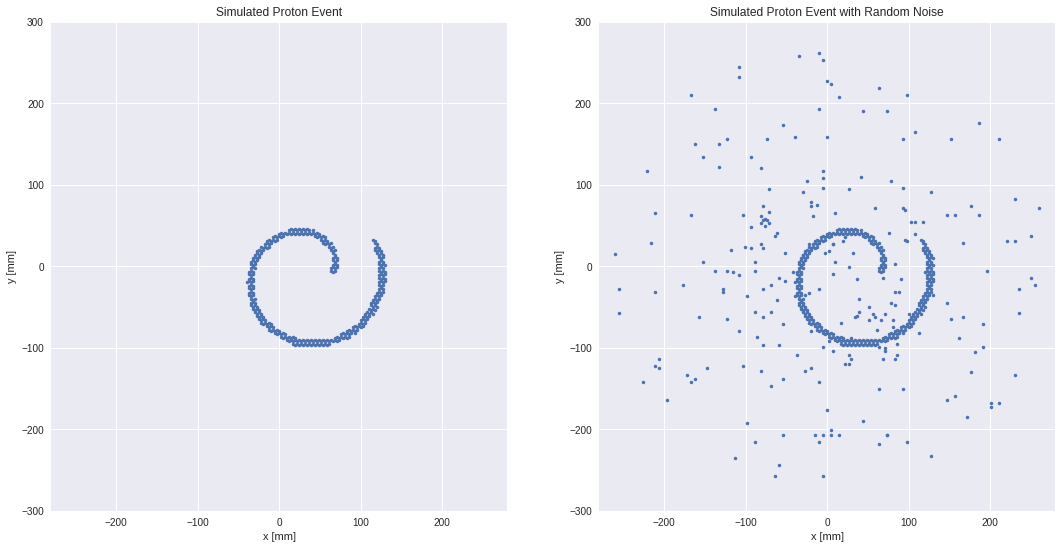

In [188]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 9))

ax[0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0].axis('equal')
        
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title('Simulated Proton Event')
ax[0].set_xlim(-300.0,300.0)
ax[0].set_ylim(-300.0,300.0)

#######################################################################################################################
ax[1].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1].axis('equal')
        
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title('Simulated Proton Event with Random Noise')
ax[1].set_xlim(-300.0,300.0)
ax[1].set_ylim(-300.0,300.0)

#plt.savefig('../plots/results/thesis/add-noise-2D.pdf')

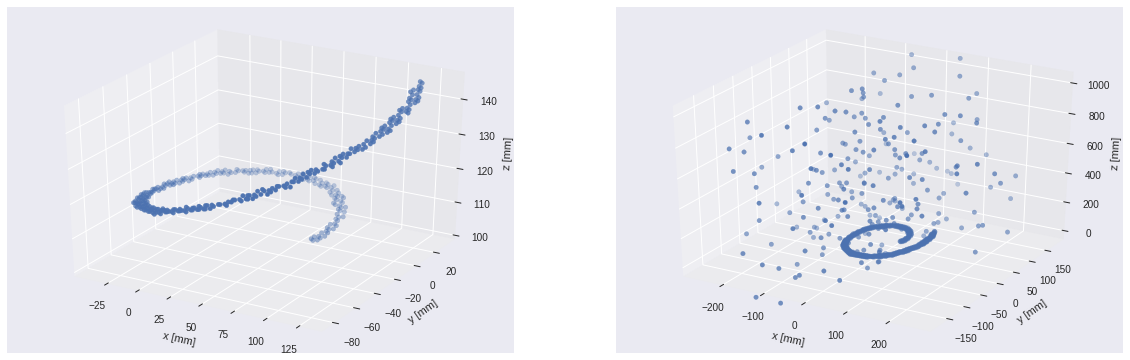

In [189]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(clean_xyzs[:,0], clean_xyzs[:,1], clean_xyzs[:,2])
ax.axis('equal')
#ax.set_title("Original Data")
ax.set_xlabel('\n x [mm]')
ax.set_ylabel('\n y [mm]')
ax.set_zlabel('\n z [mm]')


#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(noise_xyzs[:,0], noise_xyzs[:,1], noise_xyzs[:,2])
ax.axis('equal')
#ax.set_title('Efficiently Downsampled Data')
ax.set_xlabel('\n x [mm]')
ax.set_ylabel('\n y [mm]')
ax.set_zlabel('\n z [mm]')

#plt.savefig('../plots/results/thesis/add-noise-3D.pdf')

# Compare to discretized

In [29]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

x_disc = 20
y_disc = 20
z_disc = 20

discElements = x_disc*y_disc*z_disc

x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [30]:
discretized_dataClean = np.zeros((1, discElements))
discretized_xyzClean = np.zeros([clean_xyzs.shape[0], clean_xyzs.shape[1]])

num_pts = 0

for point in clean_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0        
    
#     if(discretized_dataClean[0, bucket_num] == 1):
#         print("Duplicate Found")
#         discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
#     else:
    discretized_dataClean[0,bucket_num] = 1                  
    discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataClean.sum()))

ValueError: cannot convert float NaN to integer

In [31]:
discretized_dataNoise = np.zeros((1, discElements))
discretized_xyzNoise = np.zeros([noise_xyzs.shape[0], noise_xyzs.shape[1]])

num_pts = 0

for point in noise_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    discretized_dataNoise[0,bucket_num] = 1

    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
        
    discretized_xyzNoise[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataNoise.sum()))

ValueError: cannot convert float NaN to integer

In [32]:
print(discretized_xyzClean)
#discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((discretized_xyzClean), shape=(1, discElements))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0.

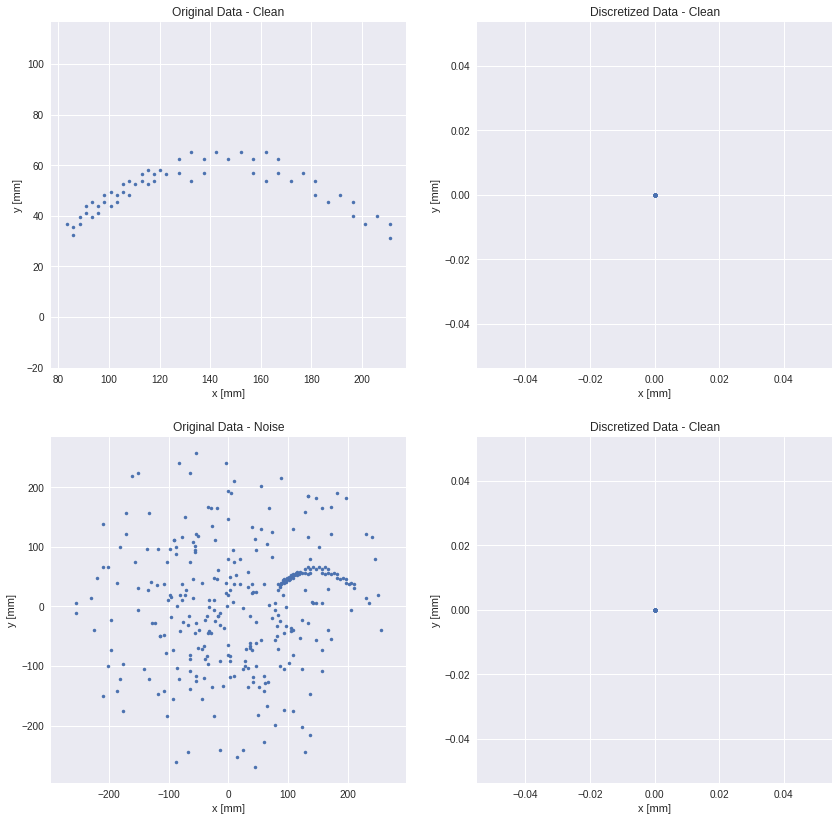

In [33]:
fig, ax = plt.subplots(2, 2, squeeze=True, figsize=(14, 14))

ax[0][0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0][0].axis('equal')
        
ax[0][0].set_xlabel('x [mm]')
ax[0][0].set_ylabel('y [mm]')
ax[0][0].set_title('Original Data - Clean')

#######################################################################################################################
ax[0][1].plot(discretized_xyzClean[:,0], discretized_xyzClean[:,1], '.')
ax[0][1].axis('equal')
        
ax[0][1].set_xlabel('x [mm]')
ax[0][1].set_ylabel('y [mm]')
ax[0][1].set_title('Discretized Data - Clean')

#######################################################################################################################
ax[1][0].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1][0].axis('equal')
        
ax[1][0].set_xlabel('x [mm]')
ax[1][0].set_ylabel('y [mm]')
ax[1][0].set_title('Original Data - Noise')

#######################################################################################################################
ax[1][1].plot(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], '.')
ax[1][1].axis('equal')
        
ax[1][1].set_xlabel('x [mm]')
ax[1][1].set_ylabel('y [mm]')
ax[1][1].set_title('Discretized Data - Clean')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparisonXY.pdf')

In [34]:
ch_colors = sns.cubehelix_palette(n_colors=6, start=0, rot=-0.4,
                                  gamma=1, hue=1, light=0.75, dark=0.1)
ch_cm = sns.blend_palette(ch_colors, as_cmap=True)

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:932: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:933: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


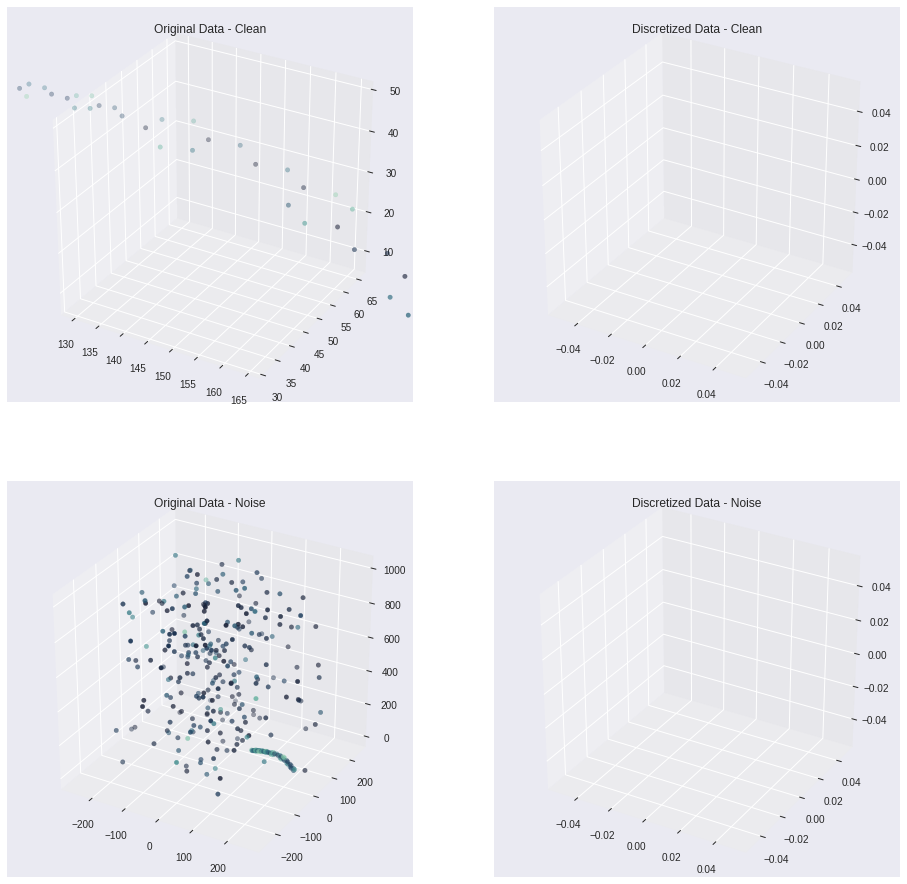

In [35]:
fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(clean_xyzs[:,0], clean_xyzs[:,1], clean_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=clean_xyzs[:,3])
ax.axis('equal')
ax.set_title("Original Data - Clean")

#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyzClean[:,0], discretized_xyzClean[:,1], discretized_xyzClean[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzClean[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Clean')

#######################################################################################################################
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter(noise_xyzs[:,0], noise_xyzs[:,1], noise_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=noise_xyzs[:,3])
ax.axis('equal')
ax.set_title('Original Data - Noise')

############################clean_xyzs###########################################################################################
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], discretized_xyzNoise[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzNoise[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Noise')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparison3D.pdf')

# pad num -> xy

In [86]:
nums = np.random.randint(0,10240, (num_noisepts, 1))

In [87]:
pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

In [88]:
xys = pcenters[nums]

In [89]:
print(xys)

[[[  9.32564678e+01   3.12053464e+01]]

 [[ -2.20870582e+02   1.16353940e+02]]

 [[  5.39905866e+01   6.23090928e+01]]

 [[ -1.47247054e+02   1.13384702e+02]]

 [[ -1.42338819e+02   3.68728882e+01]]

 [[  2.50319993e+02  -4.83434384e+01]]

 [[  2.45411757e+02  -9.08500016e+01]]

 [[ -1.57063525e+02   2.09868379e+02]]

 [[ -3.43576460e+01   1.55891265e+02]]

 [[  1.86512936e+02   1.13384702e+02]]

 [[ -4.66282339e+01  -9.95206476e+00]]

 [[  8.34399975e+01   1.67361816e+02]]

 [[ -6.13529394e+01   8.35623744e+01]]

 [[  2.45411757e+00  -1.55518732e+01]]

 [[ -2.35595287e+02  -1.07852627e+02]]

 [[  1.47247054e+01   6.52105970e+01]]

 [[ -2.15962347e+02  -1.24855252e+02]]

 [[ -1.15343526e+02  -1.55518732e+01]]

 [[ -8.83482327e+01   9.92158476e+01]]

 [[  2.45411757e+00  -3.54560027e+01]]

 [[  6.38070569e+01   2.79990422e+00]]

 [[  1.71788230e+02   1.04883389e+02]]

 [[ -2.45411757e+01  -3.68051548e+01]]

 [[ -4.90823515e+00   5.38077801e+01]]

 [[  1.52155290e+02   6.53460637e+01]]



In [90]:
print(xys.reshape(xys.shape[0], 2).shape)

(191, 2)
